In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import storage
import hashlib

def generate_md5(value):
    return hashlib.md5(value.encode()).hexdigest()

def download_from_gcs(bucket_name, files, destination_folder):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    os.makedirs(destination_folder, exist_ok=True)
    
    for file in files:
        blob = bucket.blob(file)
        destination_path = os.path.join(destination_folder, os.path.basename(file))
        blob.download_to_filename(destination_path)
        print(f"📥 Descargado: {file}")

def load_dataframes(destination_folder):
    dataframes = {}
    for file in os.listdir(destination_folder):
        if file.endswith('.csv'):
            df_name = file.replace('.csv', '').replace('_cleaned', '') + '_cleaned'
            dataframes[df_name] = pd.read_csv(os.path.join(destination_folder, file))
    return dataframes

def convert_types(dataframes):
    for name, df in dataframes.items():
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = df[col].astype(str)
    return dataframes

def process_missing_values(dataframes):
    for name, df in dataframes.items():
        numeric_df = df.select_dtypes(include=[np.number])
        for col in numeric_df.columns:
            mean = df[col].mean()
            df[col] = df[col].fillna(mean)
    print("✅ Valores nulos tratados correctamente.")


def transform_data(dataframes):
    users_cleaned = dataframes['users_cleaned'][['user_id', 'name', 'review_count', 'yelping_since']].copy()
    users_cleaned.loc[:, 'yelping_since'] = pd.to_datetime(users_cleaned['yelping_since']).dt.date
    
    reviews_cleaned = dataframes['reviews_cleaned'][['review_id', 'business_id', 'user_id', 'stars', 'text', 'date']].copy()
    reviews_cleaned.rename(columns={'date': 'review_date'}, inplace=True)
    reviews_cleaned.loc[:, 'review_date'] = pd.to_datetime(reviews_cleaned['review_date']).dt.date
    reviews_cleaned.loc[:, 'stars'] = reviews_cleaned['stars'].astype(int)
    
    business_cleaned = dataframes['business_cleaned'][['business_id', 'name', 'address', 'city', 'categories', 'latitude', 'longitude', 'review_count']].copy()
    business_cleaned.rename(columns={'name': 'business_name'}, inplace=True)

    cities = business_cleaned[['city']].drop_duplicates().copy()
    cities['city_id'] = cities['city'].apply(generate_md5)
    business_cleaned = business_cleaned.merge(cities, on='city', how='left').drop(columns=['city'])
    cities = cities[['city_id', 'city']]

    categories = business_cleaned[['categories']].drop_duplicates().copy()
    categories['category_id'] = categories['categories'].apply(generate_md5)
    business_cleaned = business_cleaned.merge(categories, on='categories', how='left')
    categories = categories[['category_id', 'categories']].copy()
    categories.rename(columns={'categories': 'category'}, inplace=True)

    return {
        'users_cleaned': users_cleaned,
        'reviews_cleaned': reviews_cleaned,
        'business_cleaned': business_cleaned,
        'cities': cities,
        'categories': categories
    }


def plot_and_export(dataframes, output_path, bucket):
    os.makedirs(output_path, exist_ok=True)
    dataframes = {k: v for k, v in dataframes.items() if v is not None}
    
    for name, df in dataframes.items():
        if not df.empty:
            numeric_df = df.select_dtypes(include=[np.number])
            for col in numeric_df.columns:
                plt.figure(figsize=(10, 5))
                sns.histplot(numeric_df[col], bins=30, kde=True)
                plt.axvline(numeric_df[col].mean(), color='r', linestyle='dashed', linewidth=2, label='Media')
                plt.title(f'Distribuci\u00f3n de {col} en {name}')
                plt.legend()
                plt.show()
            
            csv_path = os.path.join(output_path, f"{name}.csv")
            df.to_csv(csv_path, index=False)
            
            blob = bucket.blob(f"ETL/{name}.csv")
            blob.upload_from_filename(csv_path)
            print(f"☁️ Archivo subido a GCS: ETL/{name}.csv")


In [2]:
# Configurar la autenticación con la clave de servicio JSON
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "proyectofinalgogleyelp-41e96ec7a40a.json"

# Configuración
bucket_name = "dataset-pf-gyelp"
destination_folder = "./dataWorkingon"
output_path = "./output_data"

files = [
    "Yelp/processed/user_cleaned.csv",
    "Yelp/processed/reviews_cleaned.csv",
    "Yelp/processed/users_cleaned.csv",
    "Yelp/processed/tips_cleaned.csv",
    "Yelp/processed/review_cleaned.csv",
    "Yelp/processed/business_cleaned.csv",
    "Yelp/processed/business_cleaned.parquet"
]

# Inicializar cliente de almacenamiento
client = storage.Client()
bucket = client.bucket(bucket_name)

# Proceso ETL
download_from_gcs(bucket_name, files, destination_folder)



c:\Users\PC\Documents\Henry\PF\end\Lib\site-packages\google_crc32c\__init__.py:29: RuntimeWarning: As the c extension couldn't be imported, `google-crc32c` is using a pure python implementation that is significantly slower. If possible, please configure a c build environment and compile the extension
  warnings.warn(_SLOW_CRC32C_WARNING, RuntimeWarning)


📥 Descargado: Yelp/processed/user_cleaned.csv
📥 Descargado: Yelp/processed/reviews_cleaned.csv
📥 Descargado: Yelp/processed/users_cleaned.csv
📥 Descargado: Yelp/processed/tips_cleaned.csv
📥 Descargado: Yelp/processed/review_cleaned.csv
📥 Descargado: Yelp/processed/business_cleaned.csv
📥 Descargado: Yelp/processed/business_cleaned.parquet


In [3]:
# Ruta donde se guardaron los archivos descargados
base_path = "./dataWorkingon"

def load_file(file_path):
    if os.path.exists(file_path):  
        try:
            if file_path.endswith('.csv'):
                print(f"📂 Cargando CSV: {file_path}")
                return pd.read_csv(file_path, encoding='utf-8')  # Prueba con 'latin1' si falla
            elif file_path.endswith('.parquet'):
                print(f"📂 Cargando Parquet: {file_path}")
                return pd.read_parquet(file_path)
            else:
                print(f"⚠️ Formato no soportado: {file_path}")
                return None
        except Exception as e:
            print(f"❌ Error al cargar {file_path}: {e}")
            return None  
    else:
        print(f"⚠️ Archivo no encontrado: {file_path}")
        return None

# Construir rutas de archivos con base_path
dataframes = {file: load_file(os.path.join(base_path, os.path.basename(file))) for file in files}

# ✅ Revisar qué archivos se cargaron correctamente
for file, df in dataframes.items():
    if df is not None:
        print(f"✔️ {file} cargado con {len(df)} filas")

📂 Cargando CSV: ./dataWorkingon\user_cleaned.csv


C:\Users\PC\AppData\Local\Temp\ipykernel_4204\2497550506.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, encoding='utf-8')  # Prueba con 'latin1' si falla


📂 Cargando CSV: ./dataWorkingon\reviews_cleaned.csv
📂 Cargando CSV: ./dataWorkingon\users_cleaned.csv


C:\Users\PC\AppData\Local\Temp\ipykernel_4204\2497550506.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, encoding='utf-8')  # Prueba con 'latin1' si falla


📂 Cargando CSV: ./dataWorkingon\tips_cleaned.csv
📂 Cargando CSV: ./dataWorkingon\review_cleaned.csv
📂 Cargando CSV: ./dataWorkingon\business_cleaned.csv
📂 Cargando Parquet: ./dataWorkingon\business_cleaned.parquet
✔️ Yelp/processed/user_cleaned.csv cargado con 1987897 filas
✔️ Yelp/processed/reviews_cleaned.csv cargado con 6990282 filas
✔️ Yelp/processed/users_cleaned.csv cargado con 2105597 filas
✔️ Yelp/processed/tips_cleaned.csv cargado con 908915 filas
✔️ Yelp/processed/review_cleaned.csv cargado con 4559049 filas
✔️ Yelp/processed/business_cleaned.csv cargado con 150346 filas
✔️ Yelp/processed/business_cleaned.parquet cargado con 150346 filas


In [4]:
dataframes = load_dataframes(destination_folder)


C:\Users\PC\AppData\Local\Temp\ipykernel_4204\4061198868.py:28: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(os.path.join(destination_folder, file))
C:\Users\PC\AppData\Local\Temp\ipykernel_4204\4061198868.py:28: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(os.path.join(destination_folder, file))


In [5]:
convert_types(dataframes)


{'business_cleaned':                    business_id                      name  \
 0       Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
 1       mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
 2       tUFrWirKiKi_TAnsVWINQQ                    Target   
 3       MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
 4       mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   
 ...                        ...                       ...   
 150341  IUQopTMmYQG-qRtBk-8QnA              Binh's Nails   
 150342  c8GjPIOTGVmIemT7j5_SyQ      Wild Birds Unlimited   
 150343  _QAMST-NrQobXduilWEqSw         Claire's Boutique   
 150344  mtGm22y5c2UHNXDFAjaPNw  Cyclery & Fitness Center   
 150345  jV_XOycEzSlTx-65W906pg                   Sic Ink   
 
                                 address           city    state postal_code  \
 0                1616 Chapala St, Ste 2  Santa Barbara  Unknown       93101   
 1       87 Grasso Plaza Shopping Center         Affton  Unknown       63123   
 2    

In [6]:
process_missing_values(dataframes)


✅ Valores nulos tratados correctamente.


In [7]:
def check_columns(dataframes):
    for name, df in dataframes.items():
        print(f"\n🔍 {name} - Columnas y tipos de datos:")
        print(df.dtypes)
        print("-" * 50)

In [8]:
check_columns(dataframes)



🔍 business_cleaned - Columnas y tipos de datos:
business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open            bool
attributes       object
categories       object
hours            object
dtype: object
--------------------------------------------------

🔍 reviews_cleaned - Columnas y tipos de datos:
review_id       object
user_id         object
business_id     object
stars          float64
useful         float64
funny          float64
cool           float64
text            object
date            object
dtype: object
--------------------------------------------------

🔍 review_cleaned - Columnas y tipos de datos:
review_id       object
user_id         object
business_id     object
stars          float64
useful         float64
funny          float64
cool           float64
text            object

In [9]:
print(dataframes.keys())

dict_keys(['business_cleaned', 'reviews_cleaned', 'review_cleaned', 'tips_cleaned', 'users_cleaned', 'user_cleaned'])


In [10]:
transform_data(dataframes)

C:\Users\PC\AppData\Local\Temp\ipykernel_4204\4061198868.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_cleaned['yelping_since'] = pd.to_datetime(users_cleaned['yelping_since']).dt.date
C:\Users\PC\AppData\Local\Temp\ipykernel_4204\4061198868.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_cleaned.rename(columns={'date': 'review_date'}, inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_4204\4061198868.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

{'dim_user':                         user_id         name  review_count yelping_since
 0        qVc8ODYU5SZjKXVBgXdI7w       Walker           585    2007-01-25
 1        j14WgRoU_-2ZE1aw1dXrJg       Daniel          4333    2009-01-25
 2        2WnXYQFK0hXEoTxPtV2zvg        Steph           665    2008-07-25
 3        SZDeASXq7o05mMNLshsdIA         Gwen           224    2005-11-29
 4        hA5lMy-EnncsH4JoR-hFGQ        Karen            79    2007-01-05
 ...                         ...          ...           ...           ...
 2105592  4QGxxakRZeOlg_qDuxmTeQ     Jennilee            38    2012-01-19
 2105593  tmelBbVBGAzXBVfH2u_R6g        Gerry            19    2009-06-09
 2105594  tpBznnD6uJN3m_pJubj09w        Emily            26    2013-08-13
 2105595  Kst_srPw7GdYydMFYdCtzw  Heatheranne            25    2015-01-10
 2105596  mZl-mH3ZIWLRSd_FfvrXFg      Jessica            30    2015-11-30
 
 [2105597 rows x 4 columns],
 'fact_reviews':                       review_id             business

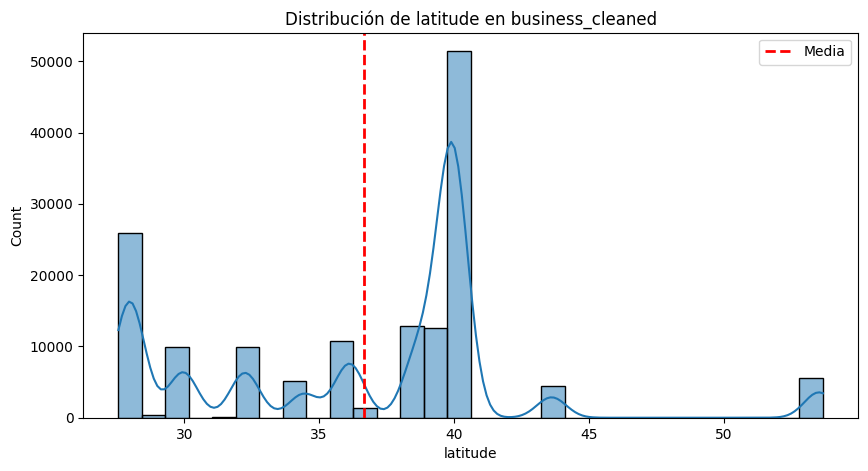

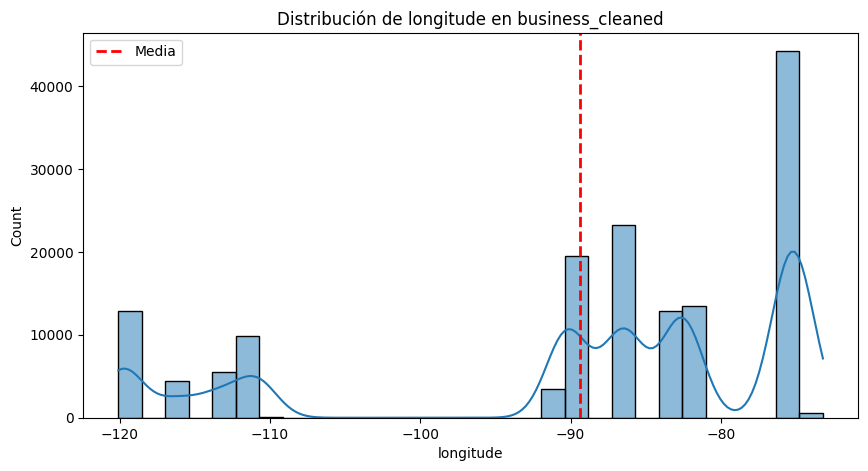

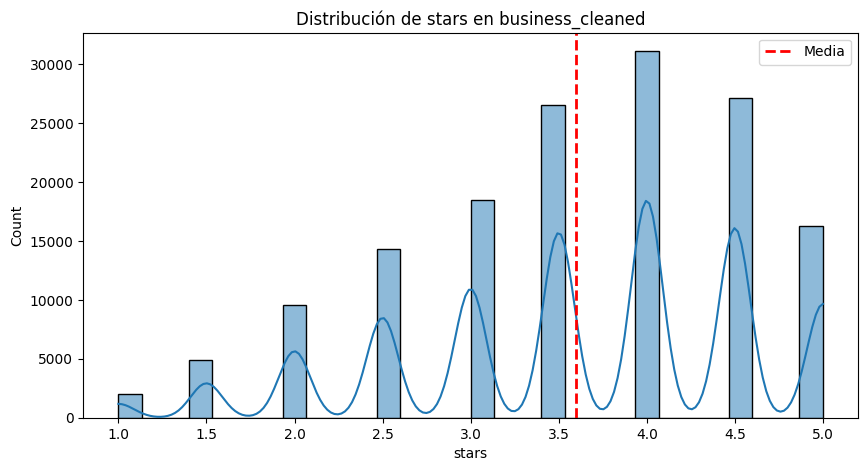

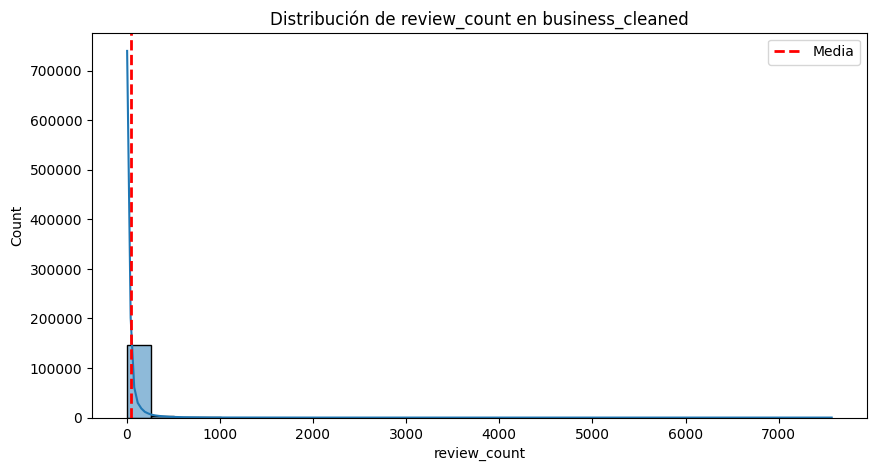

☁️ Archivo subido a GCS: ETL/business_cleaned.csv


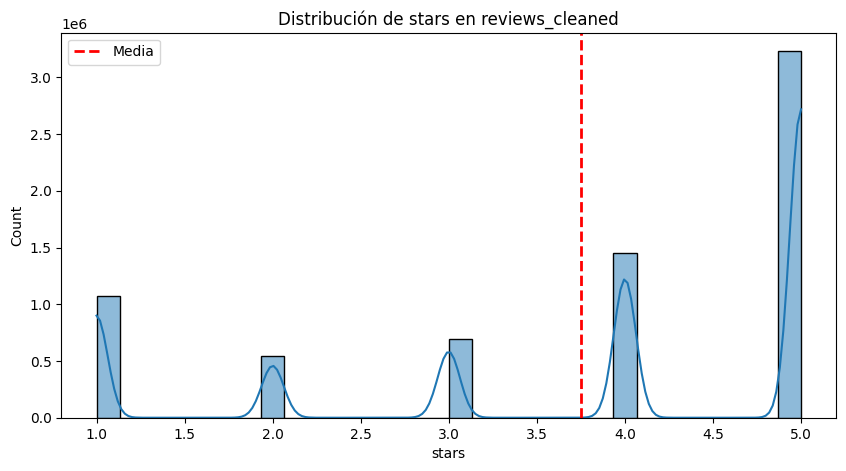

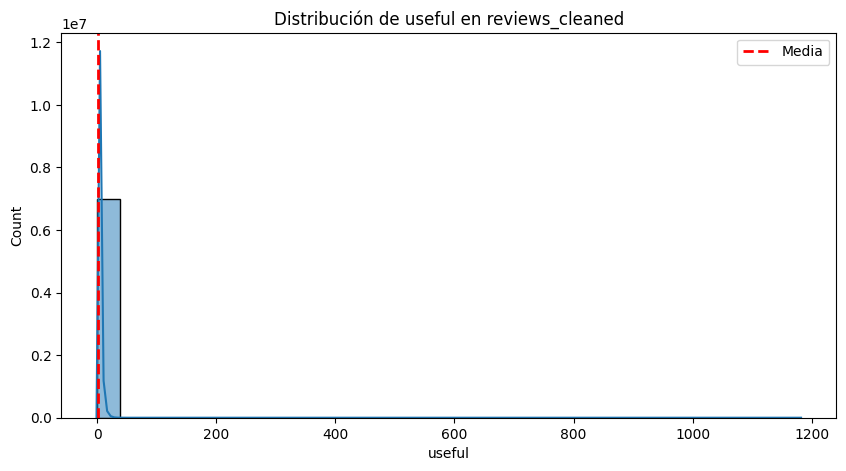

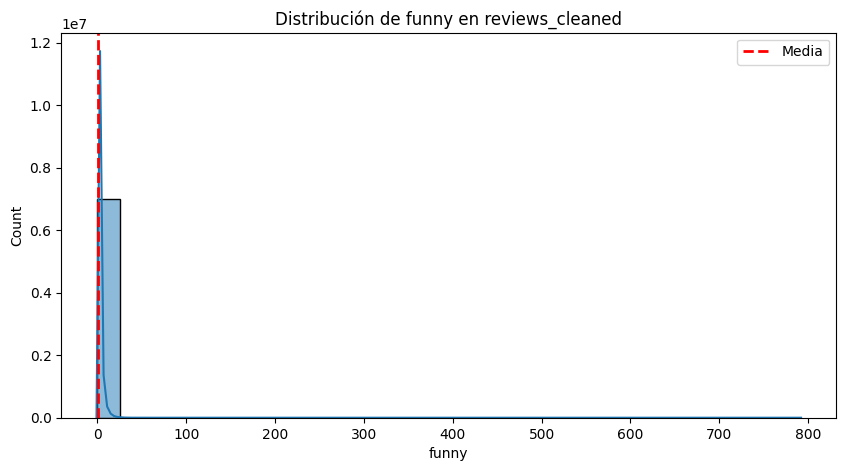

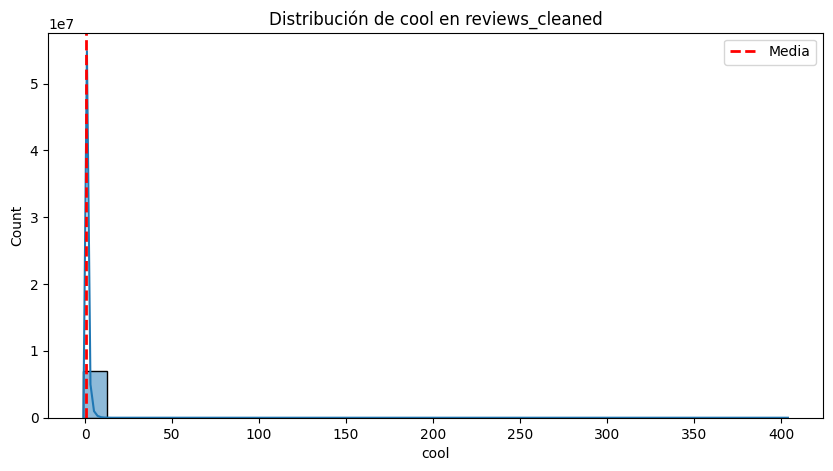

☁️ Archivo subido a GCS: ETL/reviews_cleaned.csv


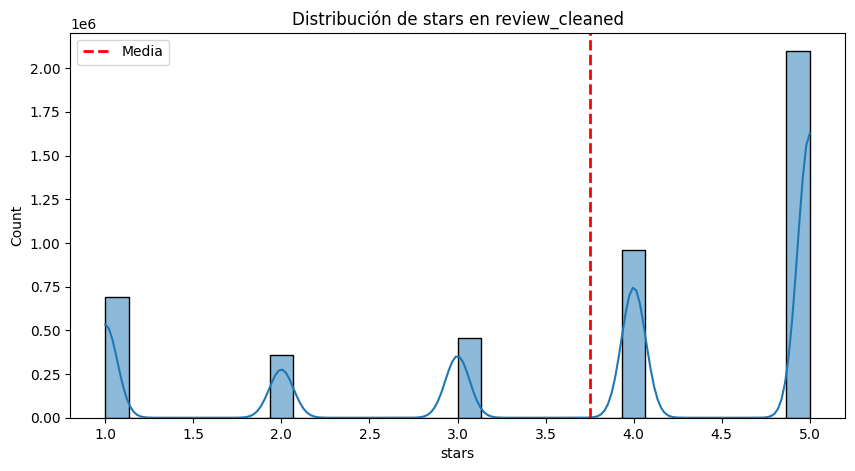

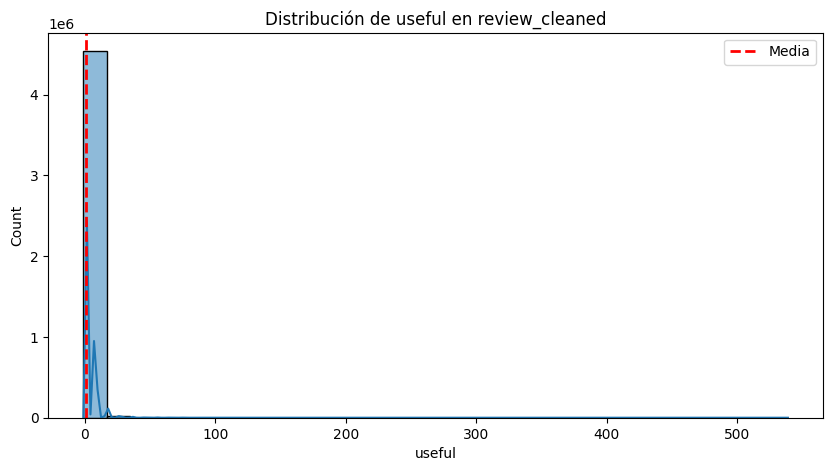

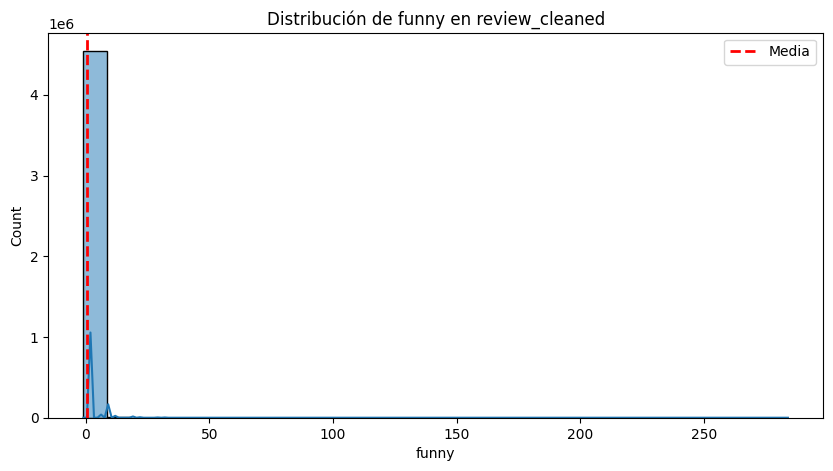

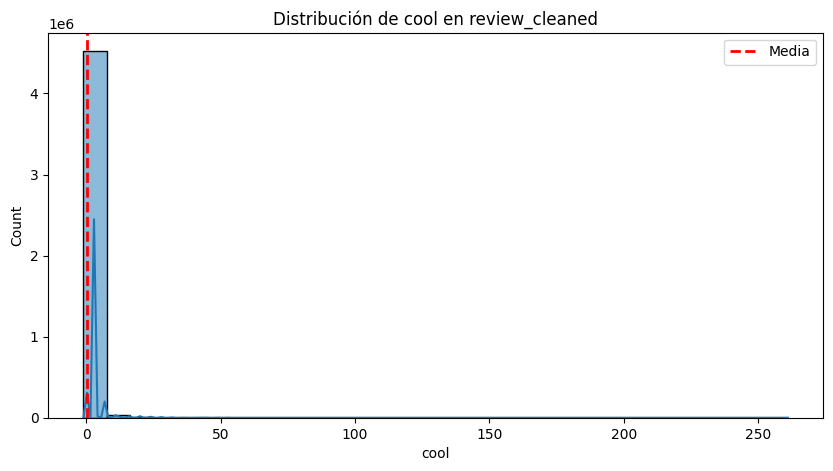

☁️ Archivo subido a GCS: ETL/review_cleaned.csv


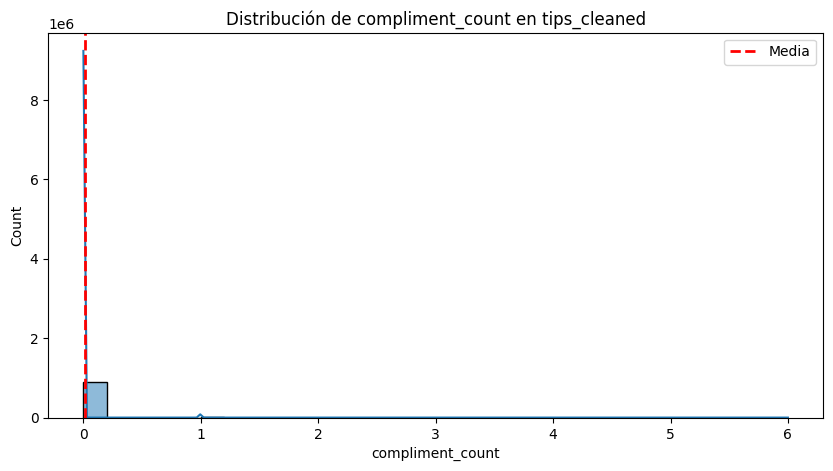

☁️ Archivo subido a GCS: ETL/tips_cleaned.csv


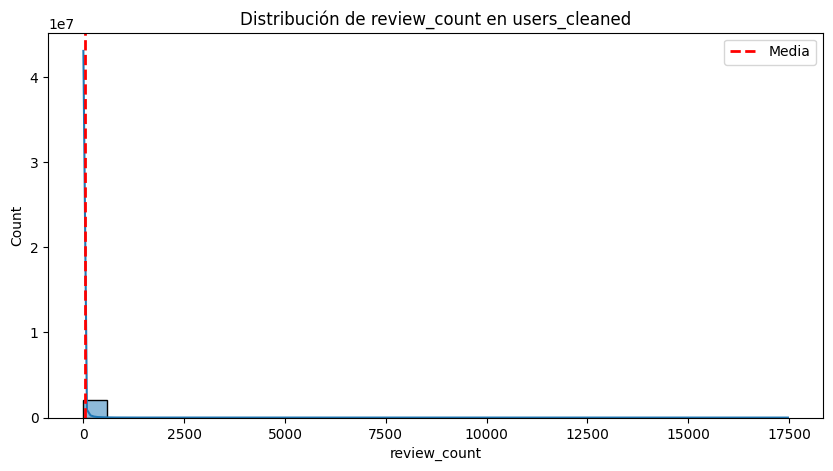

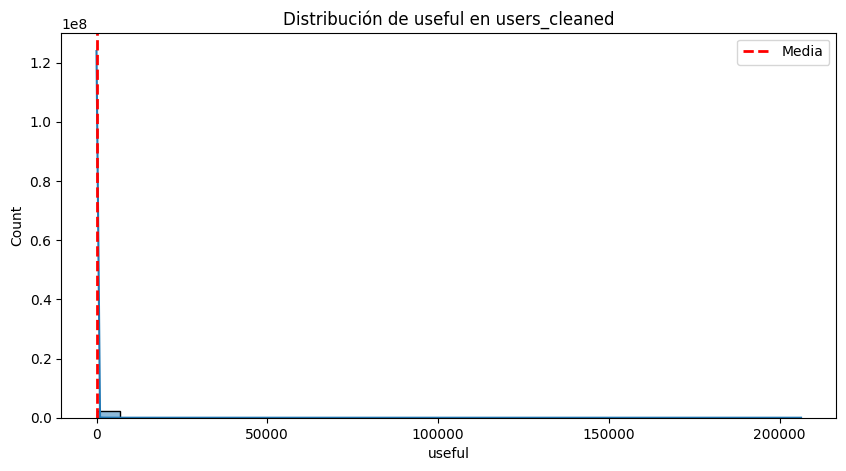

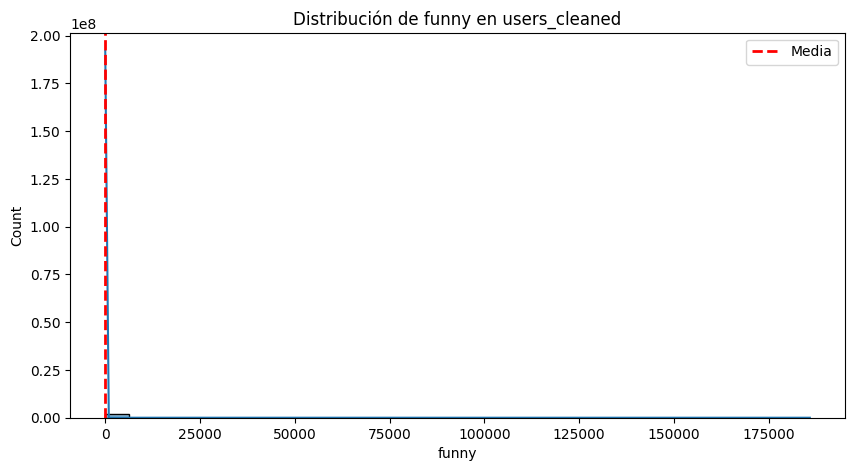

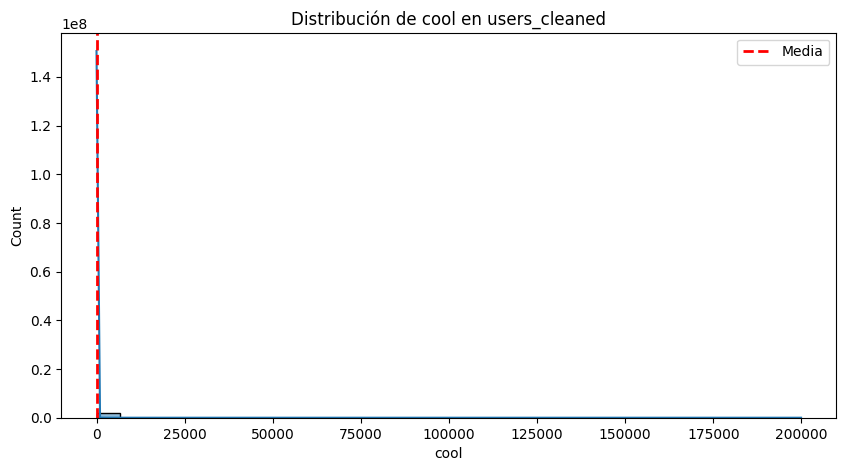

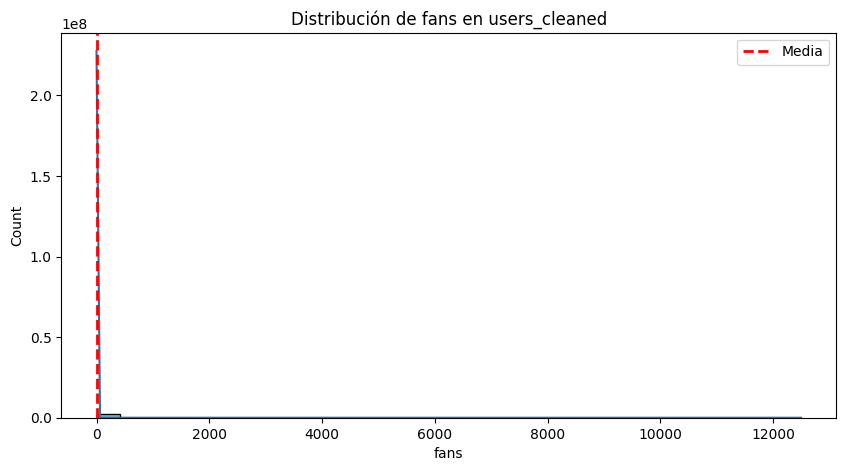

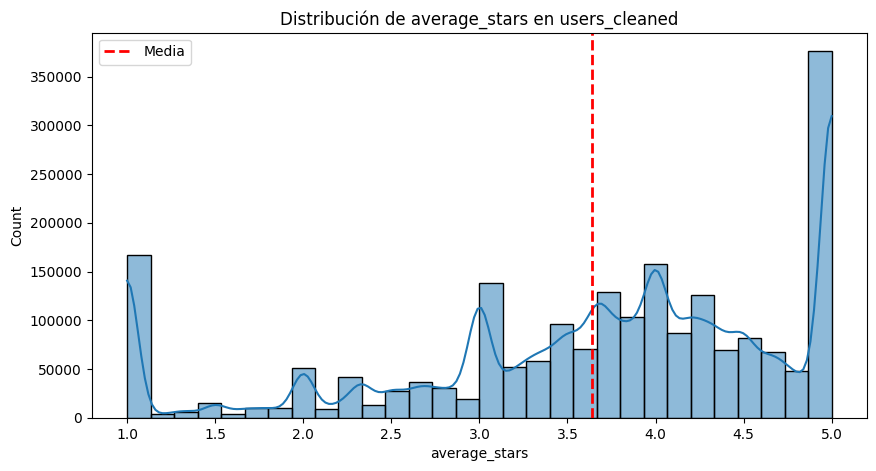

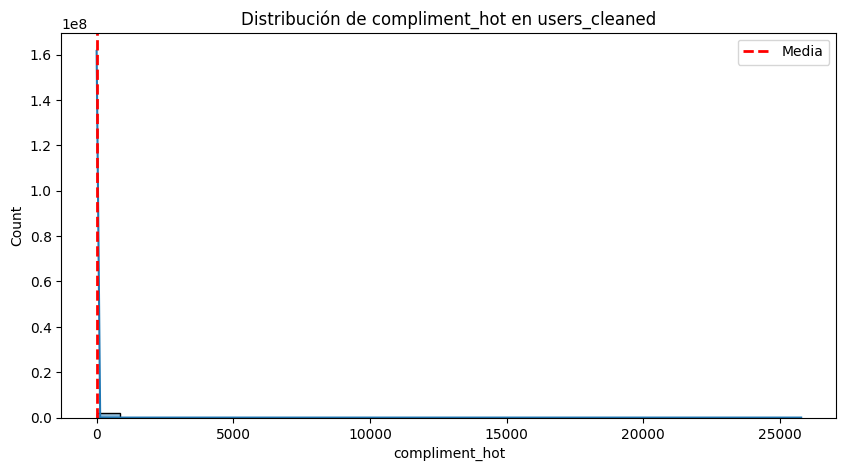

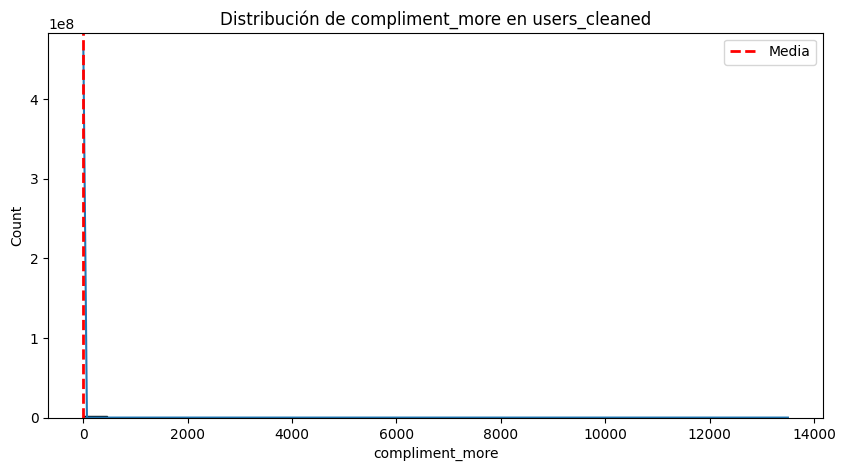

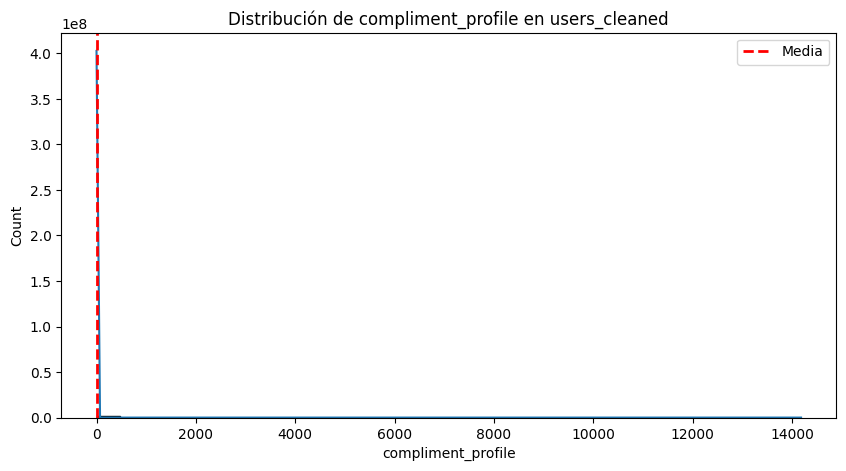

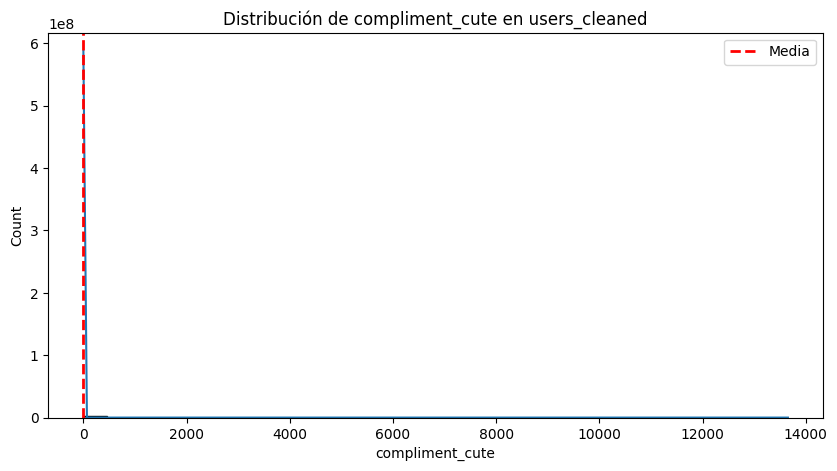

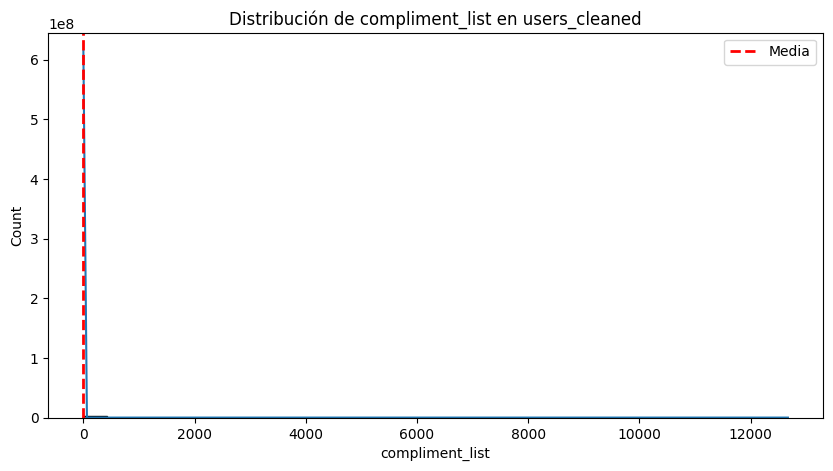

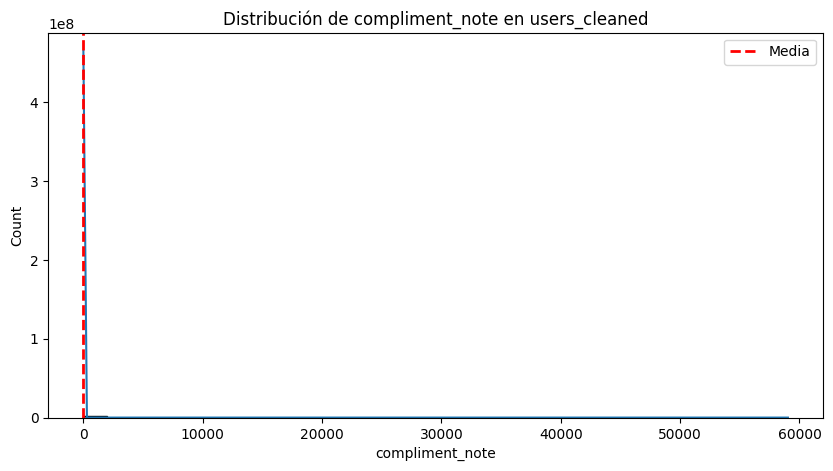

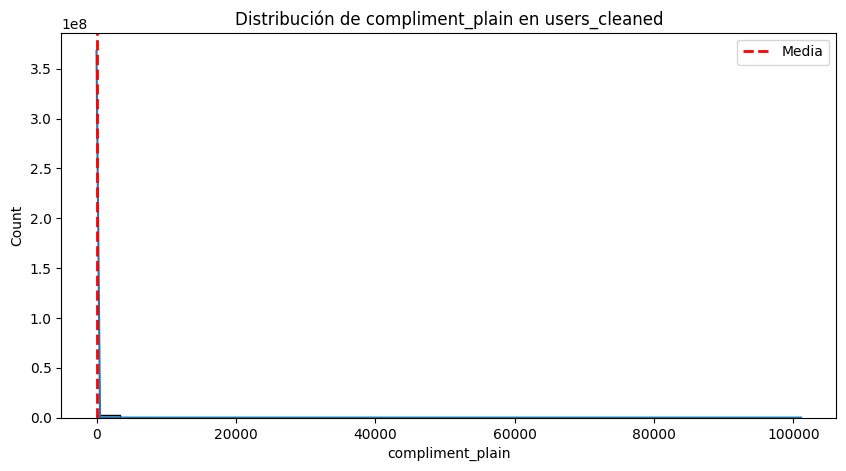

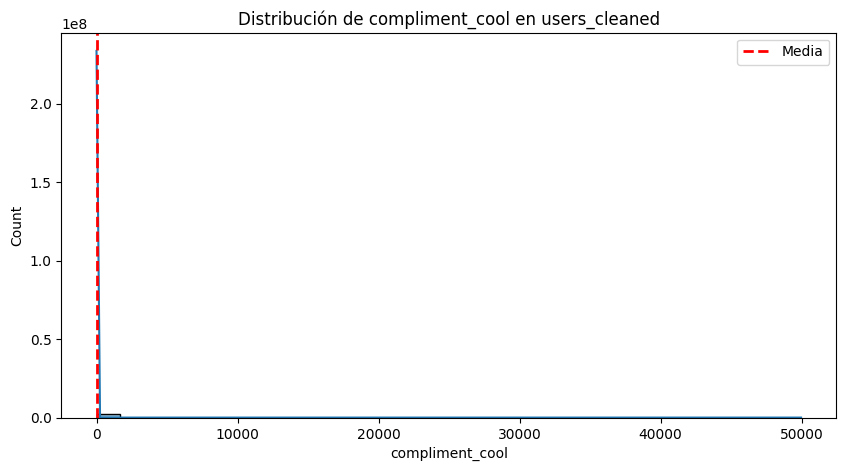

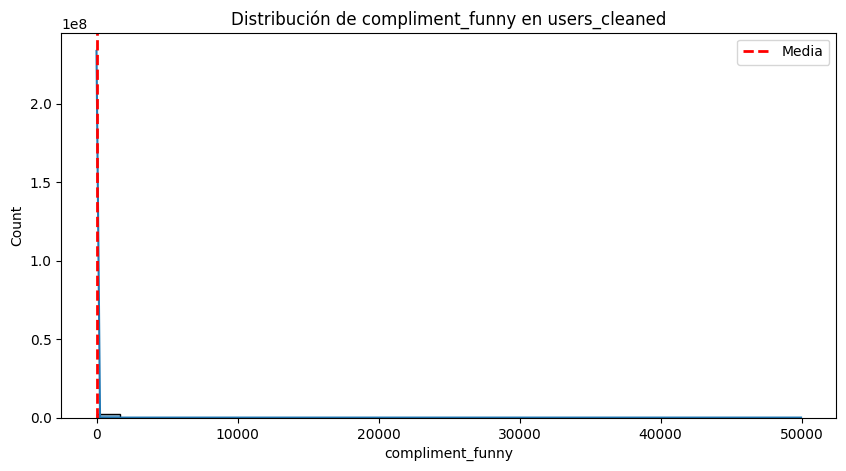

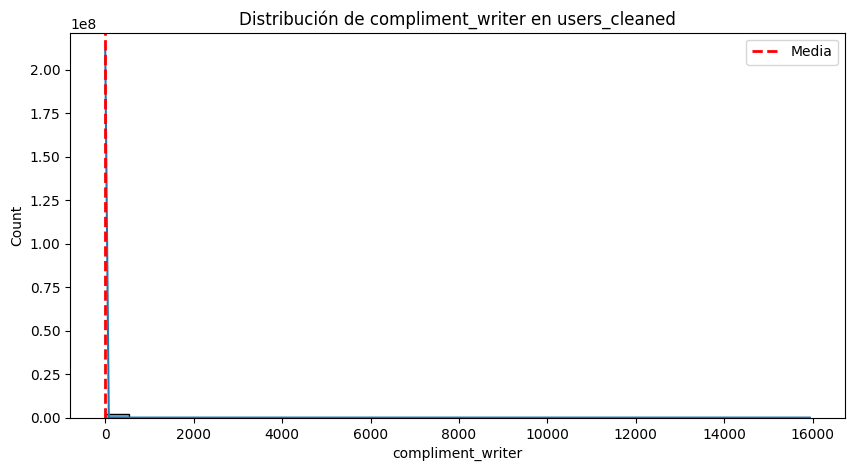

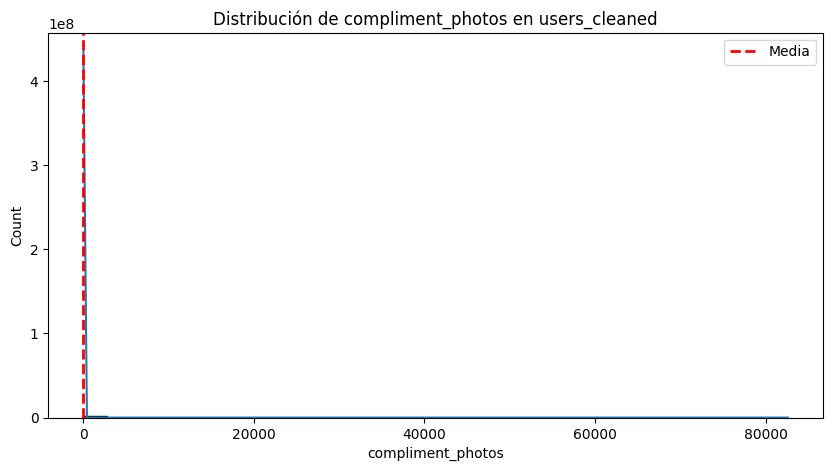

☁️ Archivo subido a GCS: ETL/users_cleaned.csv


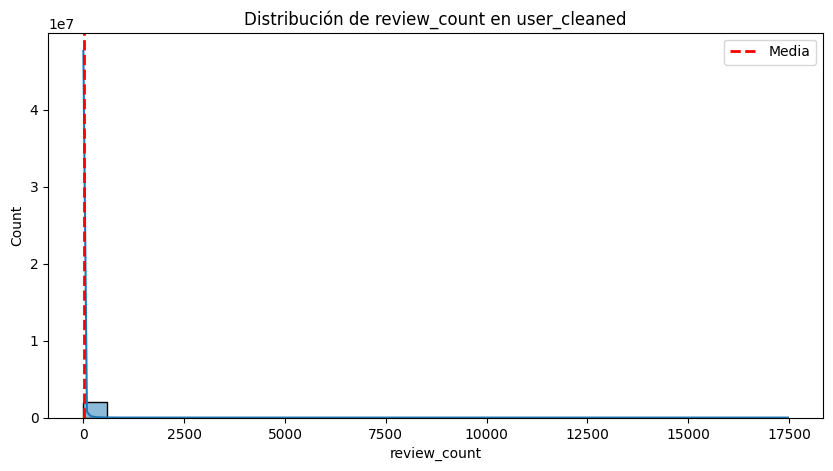

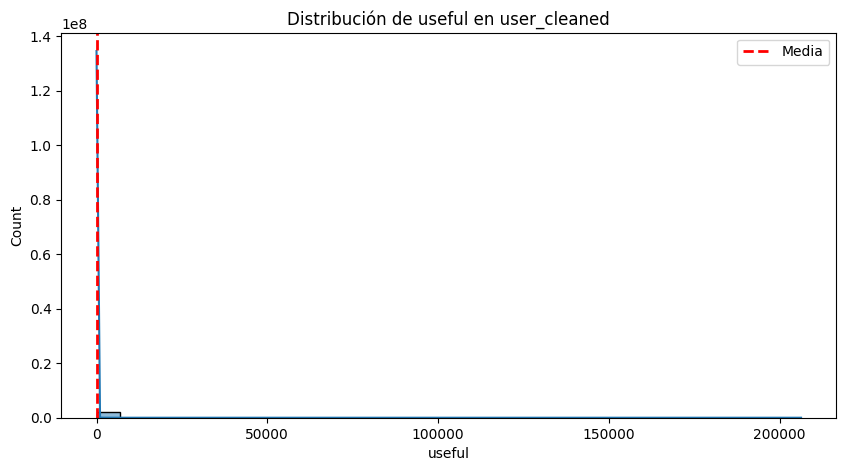

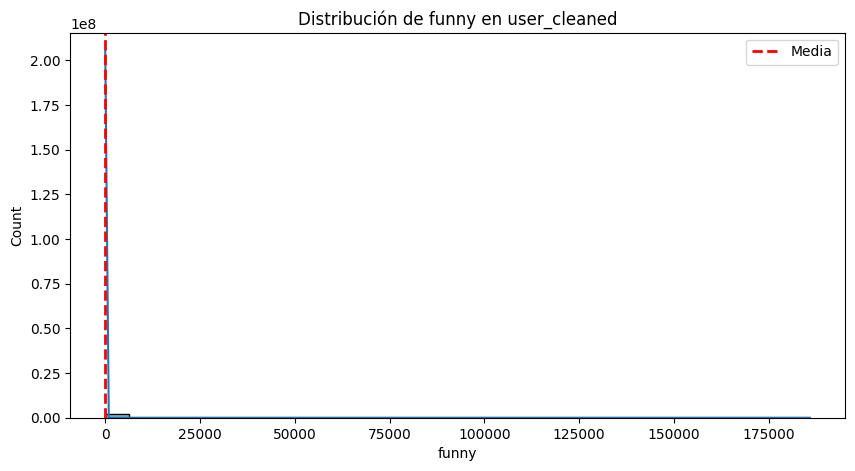

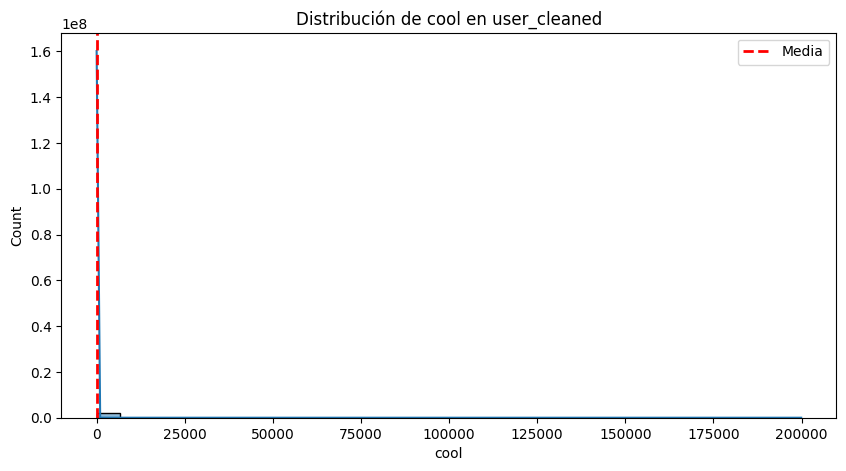

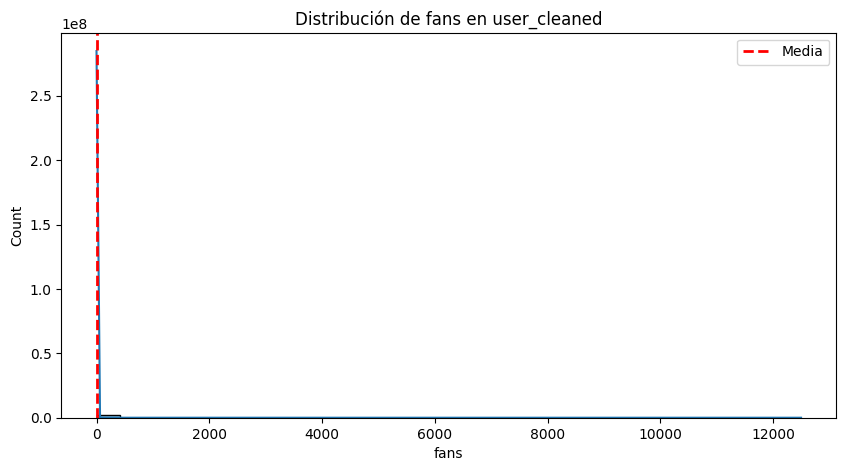

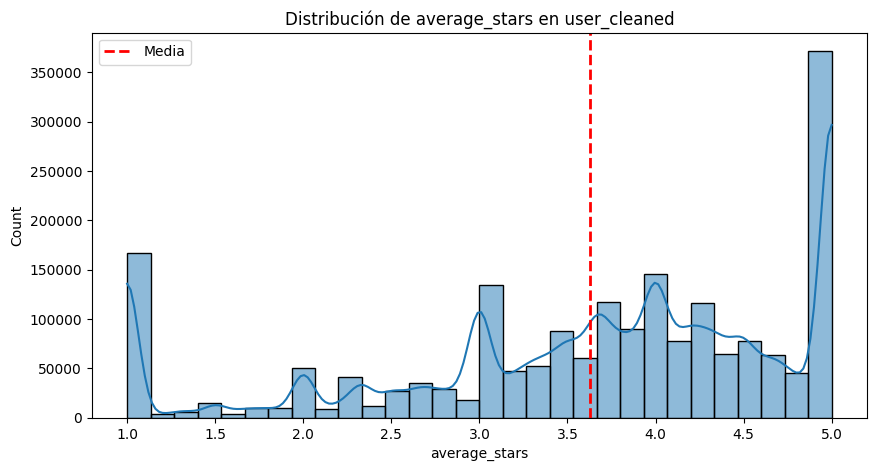

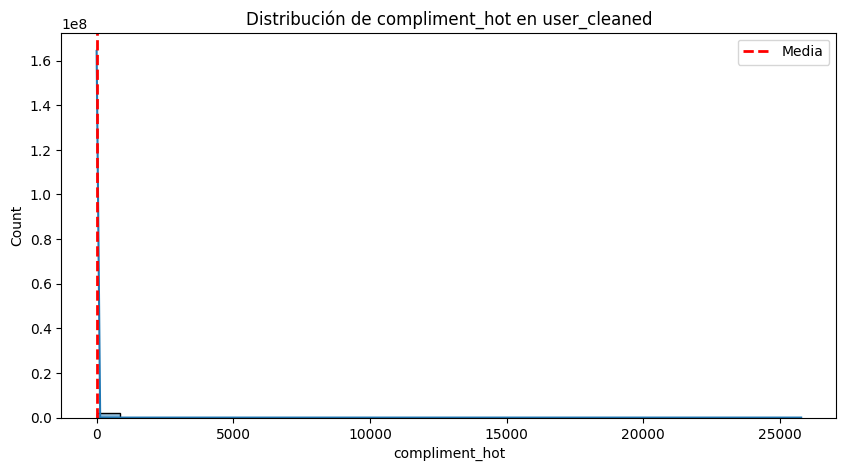

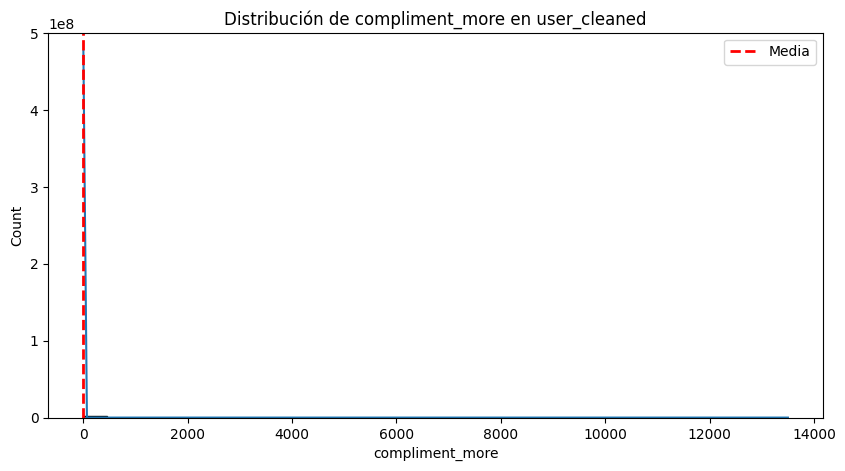

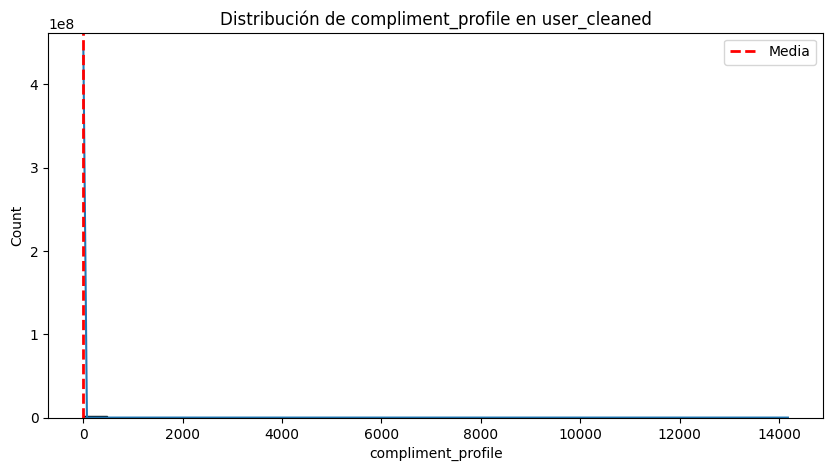

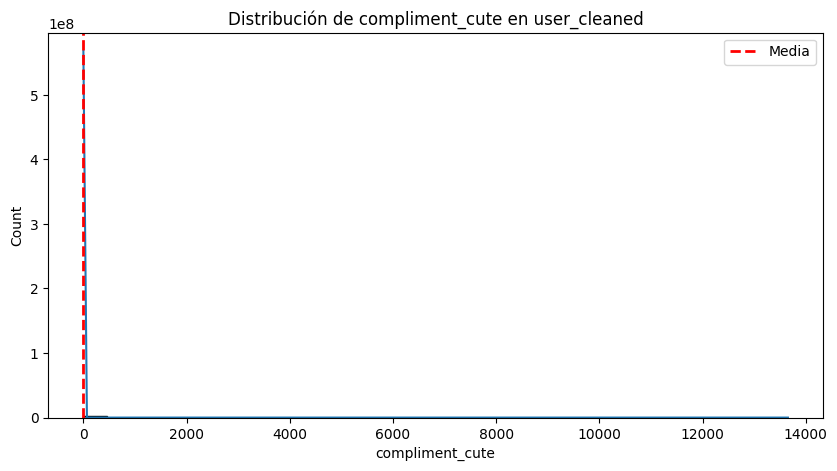

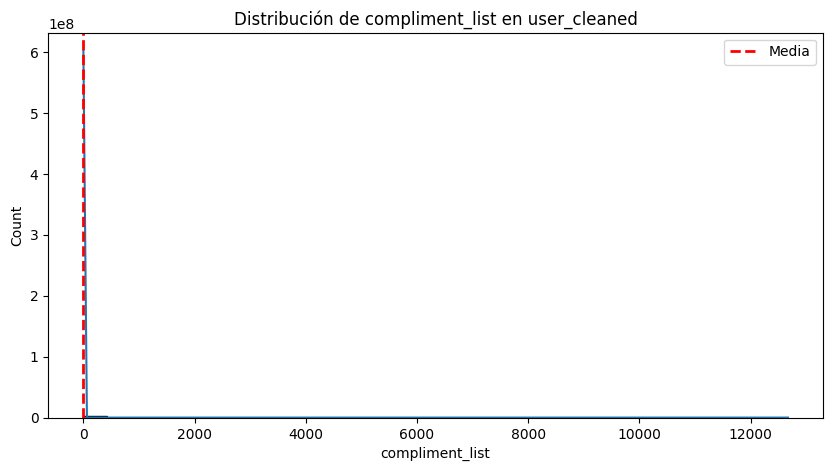

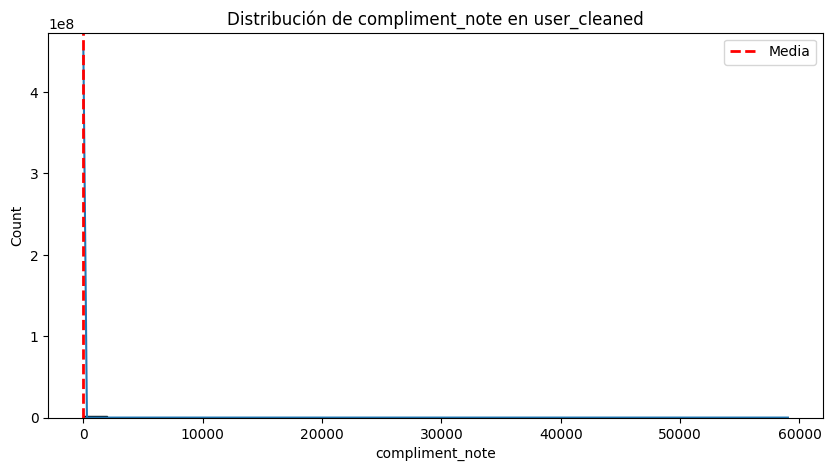

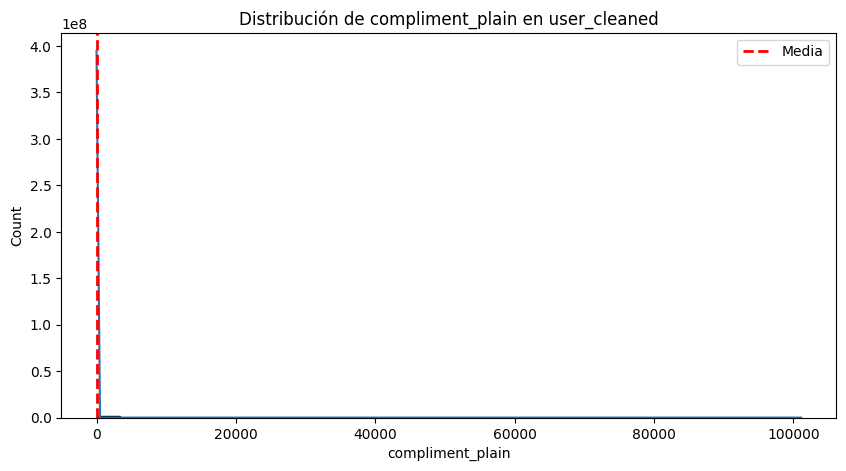

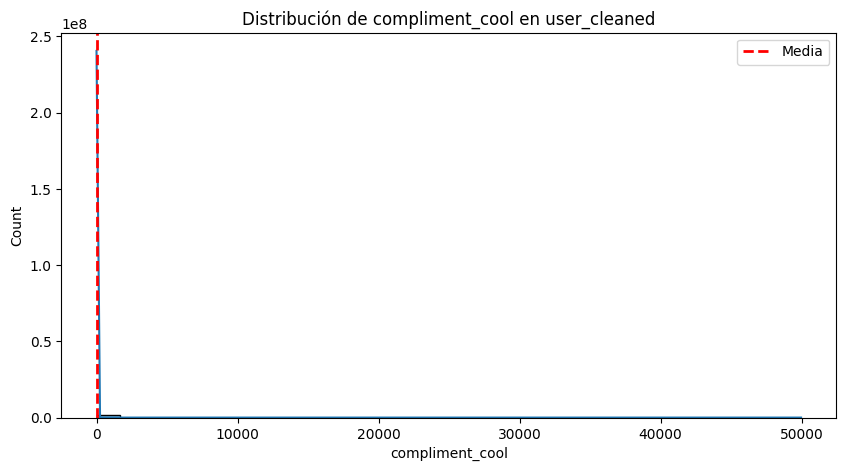

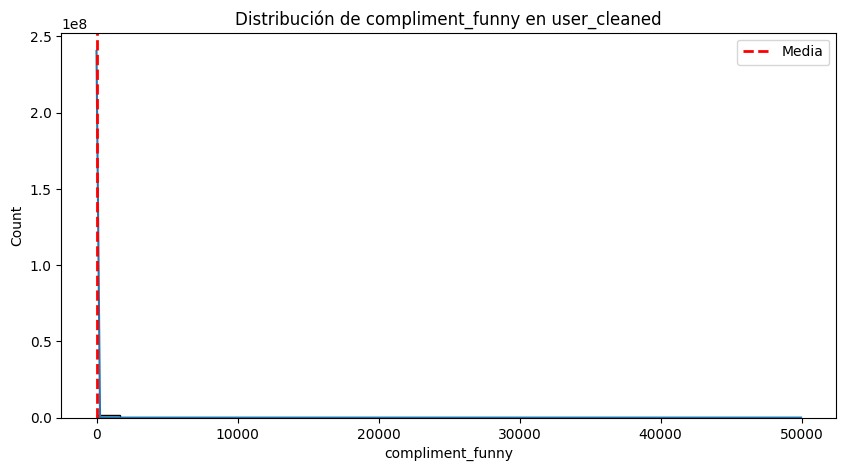

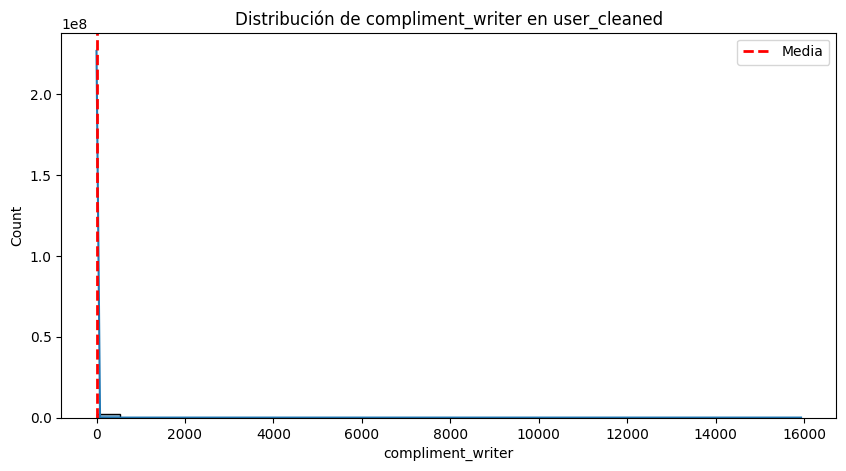

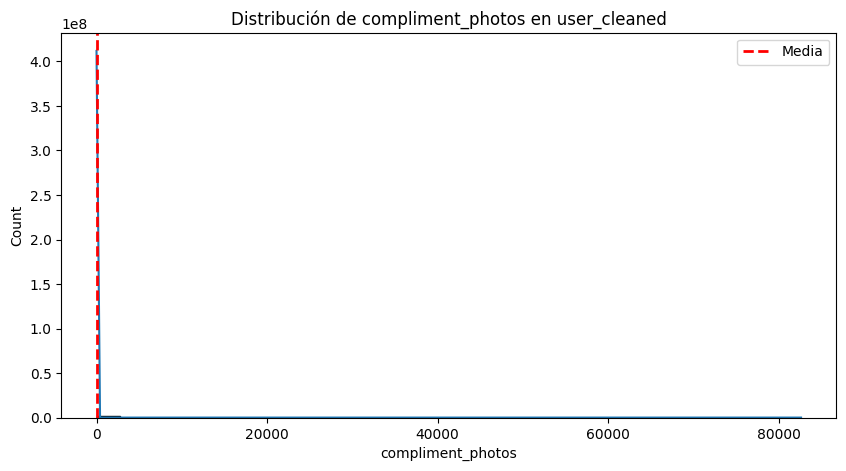

☁️ Archivo subido a GCS: ETL/user_cleaned.csv


In [14]:
# Exportar
client = storage.Client()
bucket = client.bucket(bucket_name)
plot_and_export(dataframes, output_path, bucket)

In [1]:
from google.cloud import bigquery


# Configurar credenciales
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "proyectofinalgogleyelp-41e96ec7a40a.json"

# Definir Proyecto y Dataset en BigQuery
PROJECT_ID = "proyectofinalgogleyelp"
DATASET_ID = "proyecto_dw"

# Inicializar Cliente de BigQuery
client = bigquery.Client(project=PROJECT_ID)

# Definir Esquemas de las Tablas
SCHEMAS = {
    "dim_category": [
        bigquery.SchemaField("category_id", "STRING"),
        bigquery.SchemaField("category", "STRING"),
    ],
    "dim_city": [
        bigquery.SchemaField("city_id", "STRING"),
        bigquery.SchemaField("city", "STRING"),
    ],
    "dim_business": [
        bigquery.SchemaField("business_id", "STRING"),
        bigquery.SchemaField("business_name", "STRING"),
        bigquery.SchemaField("address", "STRING"),
        bigquery.SchemaField("city_id", "STRING"),
        bigquery.SchemaField("category_id", "STRING"),
        bigquery.SchemaField("latitude", "FLOAT64"),
        bigquery.SchemaField("longitude", "FLOAT64"),
        bigquery.SchemaField("review_count", "INT64"),
    ],
    "fact_reviews": [
        bigquery.SchemaField("review_id", "STRING"),
        bigquery.SchemaField("business_id", "STRING"),
        bigquery.SchemaField("user_id", "STRING"),
        bigquery.SchemaField("category_id", "STRING"),
        bigquery.SchemaField("review_date", "DATE"),
        bigquery.SchemaField("stars", "INT64"),
        bigquery.SchemaField("text", "STRING"),
    ],
    "dim_user": [
        bigquery.SchemaField("user_id", "STRING"),
        bigquery.SchemaField("name", "STRING"),
        bigquery.SchemaField("review_count", "INT64"),
        bigquery.SchemaField("yelping_since", "DATE"),
    ],
    "fact_checkin": [
        bigquery.SchemaField("checkin_id", "STRING"),
        bigquery.SchemaField("business_id", "STRING"),
        bigquery.SchemaField("checkin_date", "DATE"),
        bigquery.SchemaField("checkin_count", "INT64"),
    ],
}

# Función para subir DataFrames a BigQuery
def upload_to_bigquery(dataframes):
    for table_name, df in dataframes.items():
        table_id = f"{PROJECT_ID}.{DATASET_ID}.{table_name}"
        print(f"Subiendo {table_name} a {table_id}...")

        # Convertir fechas al formato DATE
        for field in SCHEMAS[table_name]:
            if field.field_type == "DATE" and field.name in df.columns:
                df[field.name] = pd.to_datetime(df[field.name]).dt.date  # Convertir a formato DATE

        # Configuración de carga
        job_config = bigquery.LoadJobConfig(
            schema=SCHEMAS[table_name],
            write_disposition="WRITE_TRUNCATE",
        )

        # Cargar DataFrame en BigQuery
        job = client.load_table_from_dataframe(df, table_id, job_config=job_config)
        job.result()  # Esperar a que termine

        print(f"✅ {table_name} subida con éxito.")

# Suponiendo que `transformed_dataframes` ya está creado
upload_to_bigquery(transformed_dataframes)


NameError: name 'os' is not defined

In [ ]:
# Verificar que los DataFrames tienen las columnas correctas antes de subir
for table_name, schema_fields in SCHEMAS.items():
    if table_name in dataframes:
        expected_columns = {field.name for field in schema_fields}
        actual_columns = set(dataframes[table_name].columns)
        missing_columns = expected_columns - actual_columns
        if missing_columns:
            raise ValueError(f"La tabla {table_name} tiene columnas faltantes: {missing_columns}")
